In [1]:
#hide
!pip install fastai
!pip install fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *

path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/Users/dagmarmac/.fastai/data/mnist_png/training'),Path('/Users/dagmarmac/.fastai/data/mnist_png/testing')]

In [3]:
# Define the DataBlock
mnist_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),    # Define the blocks: ImageBlock for images and CategoryBlock for labels
    get_items=get_image_files,             # Function to get the list of image files
    splitter=GrandparentSplitter(train_name='training', valid_name='testing'),  # Split data into training and validation
    get_y=parent_label,                    # Get labels from the parent folder name
)


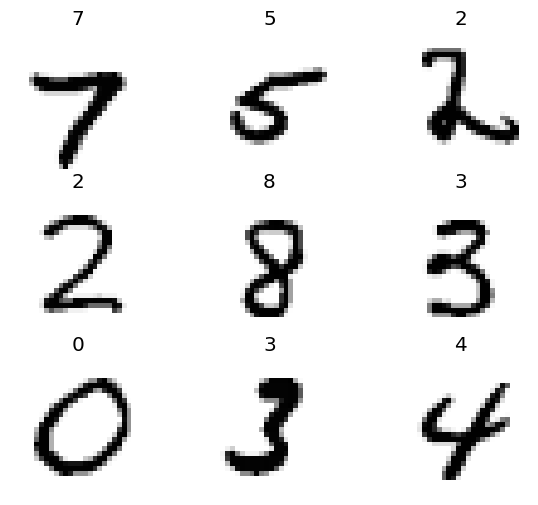

In [4]:
# Create DataLoaders
dls = mnist_block.dataloaders(path, bs=64)

# Example: Show some images
dls.show_batch(max_n=9, figsize=(7, 6))

### Define model with resnet18 known arhitecture

### Create Learner

In [5]:
pip install --upgrade torch torchvision fastai

Note: you may need to restart the kernel to use updated packages.


In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


In [7]:
simple_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 30), # input 28*28
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(30, 10),  # output 10 categories
)

In [8]:
SGD  # fastai has opt function defined

<function fastai.optimizer.SGD(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.0, wd: 'Real' = 0.0, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [9]:
LabelSmoothingCrossEntropyFlat

fastai.losses.LabelSmoothingCrossEntropyFlat

In [13]:
class Learner:
    def __init__(self, dataloaders, model, loss_fn, opt):
        self.train_dl = dataloaders[0]
        self.valid_dl = dataloaders[1]
        self.model = model
        self.opt = opt(self.model.parameters(), lr=0.01)
        self.loss_fn = loss_fn
        
    
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for i, (xb, yb) in enumerate(self.train_dl, 1):
            xb = xb.view(xb.size(0), -1)  # Flatten input to [batch_size, 28*28]
            preds = self.model(xb)
            loss = self.loss_fn(preds, yb.long())
            total_loss += loss.item()

            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

            # Print loss every 100 batches for monitoring
            if i % 100 == 0:
                print(f"Batch {i}: Loss = {loss.item():.4f}")
                
        avg_loss = total_loss / len(self.train_dl)
        print(f"Average training loss: {avg_loss:.4f}") 
        

    def batch_accuracy(self, preds, yb):
        probs = torch.softmax(preds, dim=1)
        winners = probs.argmax(dim=1)
        corrects = (winners == yb)
        accuracy = corrects.sum().float() / float(yb.size(0))
        return accuracy

    
    def validate_epoch(self):
        self.model.eval()
        accs = []
        total_loss = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for i, (xb, yb) in enumerate(self.valid_dl, 1):
                xb = xb.view(xb.size(0), -1)  # Flatten input
                preds = self.model(xb)
                loss = self.loss_fn(preds, yb.long())
                total_loss += loss.item()
                
                accs.append(self.batch_accuracy(preds, yb))
                
                # Print loss every 100 validation batches
                if i % 100 == 0:
                    print(f"Validation Batch {i}: Loss = {loss.item():.4f}")
        
        avg_loss = total_loss / len(self.valid_dl)
        avg_acc = torch.stack(accs).mean().item()
        
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
        return avg_acc


    def fit(self, n):
        for epoch in range(n):
            print(f"Epoch {epoch + 1}/{n}:")
            self.train_epoch()
            val_acc = self.validate_epoch()
            print(f"Epoch {epoch + 1} Validation Accuracy: {val_acc:.4f}")
            print('-' * 50)


    def save_model(self,file_path):
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")
        

        

## Train the model

In [14]:
mnist_learner = Learner(dls, simple_net.to(device), CrossEntropyLossFlat(), SGD)
mnist_learner.fit(5)

Epoch 1/5:
Batch 100: Loss = 0.4862
Batch 200: Loss = 0.5456
Batch 300: Loss = 0.4220
Batch 400: Loss = 0.3294
Batch 500: Loss = 0.1893
Batch 600: Loss = 0.4251
Batch 700: Loss = 0.3516
Batch 800: Loss = 0.5119
Batch 900: Loss = 0.5480
Average training loss: 0.4073
Validation Batch 100: Loss = 0.3667
Validation Loss: 0.2546, Accuracy: 0.9253
Epoch 1 Validation Accuracy: 0.9253
--------------------------------------------------
Epoch 2/5:
Batch 100: Loss = 0.3347
Batch 200: Loss = 0.5057
Batch 300: Loss = 0.3365
Batch 400: Loss = 0.5292
Batch 500: Loss = 0.6286
Batch 600: Loss = 0.5478
Batch 700: Loss = 0.3945
Batch 800: Loss = 0.3957
Batch 900: Loss = 0.4194
Average training loss: 0.3941
Validation Batch 100: Loss = 0.3671
Validation Loss: 0.2461, Accuracy: 0.9282
Epoch 2 Validation Accuracy: 0.9282
--------------------------------------------------
Epoch 3/5:
Batch 100: Loss = 0.5239
Batch 200: Loss = 0.3580
Batch 300: Loss = 0.3680
Batch 400: Loss = 0.3874
Batch 500: Loss = 0.3589
Ba

### Evaluate and interpret

In [17]:
#Saving the model after training
mnist_learner.save_model('mnist_model.pth')


Model saved to mnist_model.pth


In [35]:
ls 

digit_recognizer_fastai.ipynb        micrograd/
digit_recognizer_from_scratch.ipynb  model_full.pth
digits/                              titanic.xlsx
gender_submission.csv                train.csv
learner.ipynb


In [36]:
cd digits


/Users/dagmarmac/edu/fastai/lesson3/digits


In [37]:
ls

0.1.png   1.2.png   2.avif    5.1.png   5.3.png   9.1.jpg
1.1.jpeg  2.1.jpg   3.1.png   5.2.png   6.1.jpg   9.2.png


In [23]:
mnist_learner.model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=30, out_features=10, bias=True)
)

### Export model

In [ ]:
#learn.export('model.pkl')

### Load exported learner

In [28]:
mnist_learner.model.load_state_dict(torch.load('mnist_model.pth', weights_only=True))

# Load the saved model state
simple_net.load_state_dict(torch.load('mnist_model.pth', weights_only=True))

# Now the model is loaded with the saved weights and can be used for inference
simple_net.eval()  # Set the model to evaluation mode for inference

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=30, out_features=10, bias=True)
)

### Load and predict

In [46]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Step 1: Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Open the image and convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor(),        # Convert to a tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Step 2: Perform inference
def predict_image(image_path, model):
    model.eval()  # Set the model to evaluation mode
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image_tensor.to(device))
        probs = torch.softmax(output, dim=1)
        predicted_digit = probs.argmax(dim=1).item()
    return predicted_digit

# Example usage:
img_path = "/Users/dagmarmac/edu/fastai/lesson3/digits/9.2.png"
predicted_digit = predict_image(img_path, mnist_learner.model)
print(f"Predicted digit: {predicted_digit}")

Predicted digit: 0
